In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDSGD'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,slope_3,slope_4,slope_5,slope_10,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,1.6950,1.6978,1.6920,1.6940,0.0,488.721805,82.576383,580.781415,-401.920533,...,0.385185,0.593824,0.785340,1.690974,0.007382,9.425431,1.69665,1.69045,1.693550,1.69490
30,14/2/2000,1.6940,1.6978,1.6905,1.6922,1.0,652.173913,828.877005,594.622544,-488.691438,...,-0.106257,0.278519,0.486936,1.691249,0.006962,-21.411483,1.69780,1.69125,1.694525,1.69415
31,15/2/2000,1.6922,1.6968,1.6922,1.6935,1.0,-1500.000000,546.601261,773.745998,-183.660545,...,0.088652,-0.029516,0.355556,1.691593,0.006640,-20.712401,1.69730,1.69135,1.694325,1.69450
32,16/2/2000,1.6935,1.7049,1.6935,1.7042,1.0,182.020167,241.049694,330.781238,597.040438,...,-0.426526,0.721040,0.602125,1.692856,0.006971,92.114840,1.70085,1.69285,1.696850,1.69920
33,17/2/2000,1.7042,1.7069,1.7018,1.7055,0.0,176.552849,231.493591,287.460801,579.335905,...,0.235087,-0.350570,0.797872,1.694365,0.007263,129.312192,1.70590,1.69765,1.701775,1.70435


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,slope_3,slope_4,slope_5,slope_10,slope_20,...,roc_13,roc_14,roc_15,wcp_15,macd_15_30,cci_15,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg
29,11/2/2000,1.6978,1.6950,1.6920,1.6940,488.721805,82.576383,580.781415,-401.920533,358.658950,...,0.385185,0.593824,0.785340,1.690974,0.007382,9.425431,1.69665,1.69045,1.693550,1.69490
30,14/2/2000,1.6978,1.6940,1.6905,1.6922,652.173913,828.877005,594.622544,-488.691438,345.197473,...,-0.106257,0.278519,0.486936,1.691249,0.006962,-21.411483,1.69780,1.69125,1.694525,1.69415
31,15/2/2000,1.6968,1.6922,1.6922,1.6935,-1500.000000,546.601261,773.745998,-183.660545,318.411252,...,0.088652,-0.029516,0.355556,1.691593,0.006640,-20.712401,1.69730,1.69135,1.694325,1.69450
32,16/2/2000,1.7049,1.6935,1.6935,1.7042,182.020167,241.049694,330.781238,597.040438,309.854782,...,-0.426526,0.721040,0.602125,1.692856,0.006971,92.114840,1.70085,1.69285,1.696850,1.69920
33,17/2/2000,1.7069,1.7042,1.7018,1.7055,176.552849,231.493591,287.460801,579.335905,303.498129,...,0.235087,-0.350570,0.797872,1.694365,0.007263,129.312192,1.70590,1.69765,1.701775,1.70435


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 10% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.75752919, 0.75554197, 0.75780409, ..., 0.7564607 , 0.75629573,
        0.75766659],
       [0.75752919, 0.75401315, 0.75549746, ..., 0.75769498, 0.75779746,
        0.75651372],
       [0.75599262, 0.75126128, 0.75811164, ..., 0.75784926, 0.75748941,
        0.75705173],
       ...,
       [0.244622  , 0.24430515, 0.24727049, ..., 0.2440793 , 0.24366577,
        0.24594574],
       [0.24938537, 0.24690414, 0.24865447, ..., 0.24731929, 0.24716981,
        0.24902006],
       [0.25307314, 0.25087907, 0.2540366 , ..., 0.25071357, 0.2509819 ,
        0.25355468]])

In [10]:
input_data.shape

(5210, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.75752919, 0.75554197, 0.75780409, ..., 0.7564607 , 0.75629573,
        0.75766659],
       [0.75752919, 0.75401315, 0.75549746, ..., 0.75769498, 0.75779746,
        0.75651372],
       [0.75599262, 0.75126128, 0.75811164, ..., 0.75784926, 0.75748941,
        0.75705173],
       ...,
       [0.244622  , 0.24430515, 0.24727049, ..., 0.2440793 , 0.24366577,
        0.24594574],
       [0.24938537, 0.24690414, 0.24865447, ..., 0.24731929, 0.24716981,
        0.24902006],
       [0.25307314, 0.25087907, 0.2540366 , ..., 0.25071357, 0.2509819 ,
        0.25355468]])

In [13]:
input_data[[0],1:]

array([[0.75554197, 0.75780409, 0.75401315, 0.51629073, 0.25619323,
        0.55248152, 0.5671732 , 0.59629875, 0.6176724 , 0.75575065,
        0.6306363 , 0.66316875, 0.68284725, 0.56849605, 0.47936646,
        0.38174093, 0.65246804, 0.64127212, 0.56849605, 0.47936646,
        0.38174093, 0.44911377, 0.44872192, 0.43398298, 0.45525102,
        0.75783378, 0.61561774, 0.53172616, 0.75616881, 0.7564607 ,
        0.75629573, 0.75766659]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.75554197, 0.75780409, 0.75401315, ..., 0.7564607 ,
          0.75629573, 0.75766659]],

        [[0.75401315, 0.75549746, 0.75126128, ..., 0.75769498,
          0.75779746, 0.75651372]],

        [[0.75126128, 0.75811164, 0.75324874, ..., 0.75784926,
          0.75748941, 0.75705173]],

        ...,

        [[0.77159456, 0.76441642, 0.76012842, ..., 0.77127208,
          0.7729303 , 0.76904158]],

        [[0.76012842, 0.76549285, 0.76012842, ..., 0.76602638,
          0.7670774 , 0.76366152]],

        [[0.76012842, 0.76303245, 0.76165724, ..., 0.7653321 ,
          0.76303427, 0.76097149]]],


       [[[0.75401315, 0.75549746, 0.75126128, ..., 0.75769498,
          0.75779746, 0.75651372]],

        [[0.75126128, 0.75811164, 0.75324874, ..., 0.75784926,
          0.75748941, 0.75705173]],

        [[0.75324874, 0.76011072, 0.76960709, ..., 0.76016354,
          0.76137851, 0.76427638]],

        ...,

        [[0.76012842, 0.76549285, 0.76012842, ..., 0.76602638,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4644, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4644/4644 [==============================] - 9s 2ms/step - loss: 0.0128
Epoch 2/5
4644/4644 [==============================] - 8s 2ms/step - loss: 3.3252e-04
Epoch 3/5
4644/4644 [==============================] - 7s 1ms/step - loss: 2.496

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([1.3252, 1.3254, 1.3154, 1.3132, 1.3149, 1.3201, 1.3239, 1.3257,
       1.3246, 1.3213, 1.3246, 1.3264, 1.3286, 1.3233, 1.3214, 1.3201,
       1.3188, 1.3186, 1.3197, 1.3172, 1.3145, 1.3128, 1.3146, 1.3183,
       1.3193, 1.3194, 1.3194, 1.3178, 1.3173, 1.3153, 1.3105, 1.3129,
       1.3137, 1.3119, 1.313 , 1.3131, 1.3156, 1.317 , 1.3197, 1.3168,
       1.3119, 1.3099, 1.3132, 1.3131, 1.3134, 1.3119, 1.3121, 1.3121,
       1.3174, 1.3262, 1.3276, 1.3297, 1.3291, 1.3288, 1.3262, 1.3343,
       1.3371, 1.3368, 1.336 , 1.3374, 1.3416, 1.3462, 1.349 , 1.3386,
       1.336 , 1.3457, 1.3457, 1.3436, 1.3459, 1.3472, 1.3414, 1.3464,
       1.345 , 1.3424, 1.3431, 1.3484, 1.3471, 1.3407, 1.3401, 1.3393,
       1.3369, 1.3348, 1.3342, 1.3372, 1.3361, 1.3377, 1.3395, 1.345 ,
       1.3519, 1.3535, 1.36  , 1.359 , 1.3642, 1.3596, 1.3654, 1.3639,
       1.3685, 1.3705, 1.3688, 1.3716, 1.3746, 1.3658, 1.3676, 1.3663,
       1.3586, 1.3587, 1.3644, 1.3652, 1.369 , 1.3671, 1.3656, 1.37  ,
      

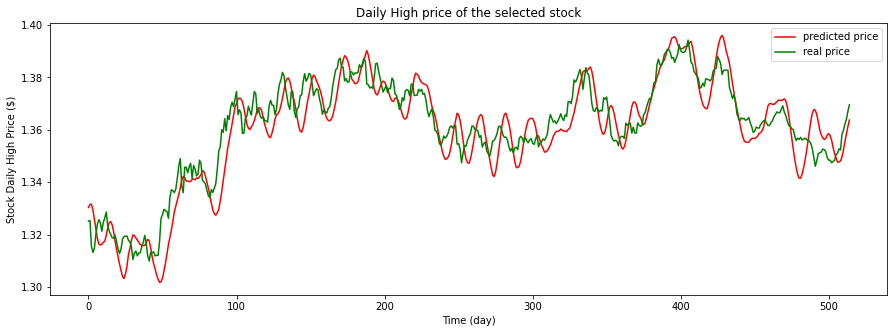

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,1.3252,1.330371,NaN,NaN
1,1.3254,1.331549,1.330371,0.001178
2,1.3154,1.331577,1.331549,0.000028
3,1.3132,1.329362,1.331577,-0.002215
4,1.3149,1.325692,1.329362,-0.003669
...,...,...,...,...
510,1.3598,1.352348,1.349576,0.002772
511,1.3622,1.355599,1.352348,0.003251
512,1.3640,1.358537,1.355599,0.002938
513,1.3671,1.361263,1.358537,0.002726


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,1.3252,1.330371,NaN,NaN,NaN,1.322875,NaN
1,1.3254,1.331549,1.330371,0.001178,0.177751,1.316950,-0.004479
2,1.3154,1.331577,1.331549,0.000028,0.004216,1.310575,-0.004841
3,1.3132,1.329362,1.331577,-0.002215,-0.337361,1.310600,0.000019
4,1.3149,1.325692,1.329362,-0.003669,-0.558112,1.313050,0.001869
5,1.3201,1.321884,1.325692,-0.003808,-0.576912,1.317625,0.003484
6,1.3239,1.318530,1.321884,-0.003355,-0.506790,1.322000,0.003320
7,1.3257,1.316379,1.318530,-0.002151,-0.324464,1.320400,-0.001210
8,1.3246,1.316024,1.316379,-0.000355,-0.053537,1.320475,0.000057
9,1.3213,1.316266,1.316024,0.000242,0.036567,1.317000,-0.002632


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

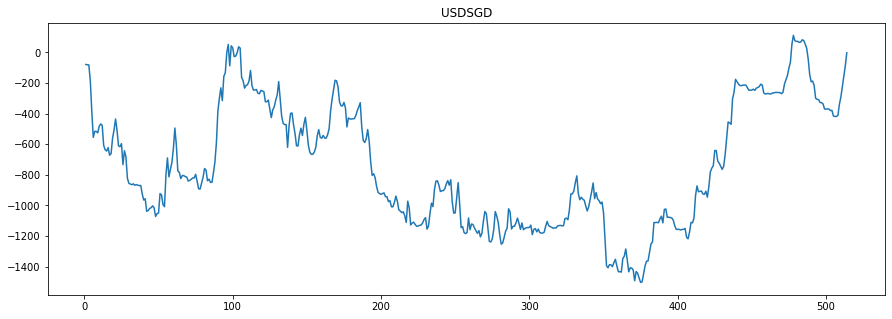

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.title(currency_name)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-0.0018744834668494637

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.0196850393700787

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 1555.419081092857 , from day 97 , to day 375
